In [1]:
import open3d as o3d
import numpy as np
from open3d.web_visualizer import draw
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [39]:
# Load files
# bin_path = 'DAIR/010000/010000.bin'
# labels_path = 'DAIR/010000/010000_label.txt'
# img_path = 'DAIR/010000/010000.png'
# calib_path = 'DAIR/010000/010000_calib.txt'

# bin_path = '/home/javier/datasets/DAIR/single-infrastructure-side-mmdet/training/velodyne/001339.bin'
# labels_path = '/home/javier/datasets/DAIR/single-infrastructure-side-mmdet/training/label_2/001339.txt'
# img_path = '/home/javier/datasets/DAIR/single-infrastructure-side-mmdet/training/image_2/001339.png'
# calib_path = '/home/javier/datasets/DAIR/single-infrastructure-side-mmdet/training/calib/001339.txt'

bin_path = 'kitti/001856/001856.bin'
labels_path = 'kitti/001856/001856_label.txt'
img_path = 'kitti/001856/001856.png'
calib_path = 'kitti/001856/001856_calib.txt'

In [40]:
# Read pc from bin file
with open(bin_path, 'rb') as f:
    points = np.fromfile(f, dtype=np.float32, count=-1).reshape([-1, 4])

pcd_bin = o3d.geometry.PointCloud()
pcd_bin.points = o3d.utility.Vector3dVector(points[:, :3])
print(pcd_bin)

PointCloud with 124673 points.


In [41]:
def process_label_file(file_path):
    labels = []
    with open(file_path, 'r') as file:
        for line in file:
            label = process_label_line(line)
            labels.append(label)
    return labels

def process_label_line(label_line):
    label_line = label_line.split(' ')
    label = dict()
    label['type'] = label_line[0]
    label['truncated'] = float(label_line[1])
    label['occluded'] = int(label_line[2])
    label['alpha'] = float(label_line[3])
    label['bbox'] = [float(label_line[i]) for i in range(4, 8)]
    label['dimensions'] = [float(label_line[i]) for i in range(8, 11)]
    label['location'] = [float(label_line[i]) for i in range(11, 14)]
    label['rotation_y'] = float(label_line[14])
    label['score'] = float(label_line[15]) if len(label_line) == 16 else None
    return label

def process_calib_file(file_path):
    calib = dict()
    with open(file_path, 'r') as file:
        for line in file:
            line = line.split(' ')
            if line[0] == 'P2:':
                calib['P2'] = [float(line[i]) for i in range(1, len(line))]
            elif line[0] == 'Tr_velo_to_cam:':
                calib['Tr_velo_to_cam'] = [float(line[i]) for i in range(1, len(line))]
            elif line[0] == 'R0_rect:':
                calib['R0_rect'] = [float(line[i]) for i in range(1, len(line))]
            elif line[0] == 'Tr_imu_to_velo:':
                calib['Tr_imu_to_velo'] = [float(line[i]) for i in range(1, len(line))]
    return calib

In [47]:
def get_lidar_in_cam_T(calib):
    Tr_velo_to_cam = np.array(calib['Tr_velo_to_cam'])
    Tr_velo_to_cam = Tr_velo_to_cam.reshape(3, 4)
    R = Tr_velo_to_cam[0:3, 0:3]
    T = Tr_velo_to_cam[0:3, 3]
    lidar_in_cam_T = np.eye(4)
    lidar_in_cam_T[0:3, 0:3] = R.T
    lidar_in_cam_T[0:3, 3] = -R.T @ T
    return lidar_in_cam_T

def generate_bbox(label, calib):
    # Extract label info
    dimensions = label['dimensions']
    position = label['location']
    rotation_y = label['rotation_y']
    
    # Generate bbox
    box = o3d.geometry.TriangleMesh.create_box(width=dimensions[2], height=dimensions[1], depth=dimensions[0])
    box.paint_uniform_color([1.0, 0.0, 0.0]) # Set color to red

    center = box.get_center()

    # Convert position to lidar coordinates
    lidar_in_cam_T = get_lidar_in_cam_T(calib)
    pos_in_cam = np.array(position + [1])

    pos_in_lidar = lidar_in_cam_T @ pos_in_cam

    # Translate box
    box.translate([pos_in_lidar[0], pos_in_lidar[1], pos_in_lidar[2]])

    # Translate box to center
    box.translate([-dimensions[2]/2, -dimensions[1]/2, 0])

    # Rotate box
    center = box.get_center()
    rotation = box.get_rotation_matrix_from_xyz((0, 0, -rotation_y - np.pi/2)) # Notice the negative sign for rotation_y
    box.rotate(rotation, center=center)

    lines = o3d.geometry.LineSet.create_from_triangle_mesh(box)
    # Remove lines that connect non-adjacent points
    lines.lines = o3d.utility.Vector2iVector(np.array([[0, 1], [2, 0], [2, 3], [3, 1], [4, 5], [4, 6], [6, 7], [7, 5], [0, 4], [1, 5], [2, 6], [3, 7]]))
    lines.paint_uniform_color([1, 0, 0])

    return lines


In [48]:
# Draw rectangles in image
def generate_img(img_path, label):
    # Read image
    img = mpimg.imread(img_path)
    
    # Create rectangles
    rect = plt.Rectangle((label['bbox'][0], label['bbox'][1]), label['bbox'][2] - label['bbox'][0], label['bbox'][3] - label['bbox'][1], linewidth=1, edgecolor='r', facecolor='none')

    # Add rectangles to image
    fig, ax = plt.subplots(1)
    ax.add_patch(rect)
    
    # Show image
    plt.imshow(img)

## Visualize one label

[Open3D INFO] Window window_14 created.


WebVisualizer(window_uid='window_14')

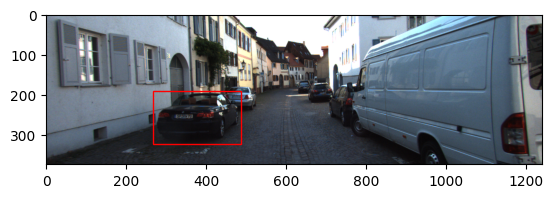

[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceServers
[Open3D INFO] [Called HTTP API (custom handshake)] /api/call
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open

[902:133][771019] (stun_port.cc:96): Binding request timed out from 163.117.150.x:52683 (enp4s0)
[902:140][771019] (stun_port.cc:96): Binding request timed out from 163.117.150.x:34400 (enp4s0)


In [49]:
# MAIN
labels = process_label_file(labels_path)
calib = process_calib_file(calib_path)

label = labels[0]

# Proccess img
generate_img(img_path, label)

# Generate bbox
lines = generate_bbox(label, calib)

# Draw bbox into point cloud
draw([pcd_bin, lines], width=900, height=600, point_size=2)

## Visualize more cars

[Open3D INFO] Window window_15 created.


WebVisualizer(window_uid='window_15')

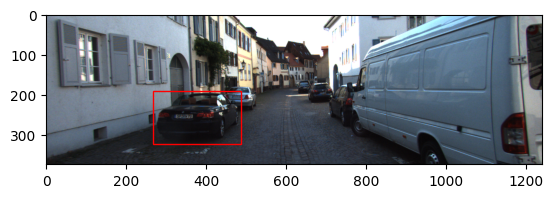

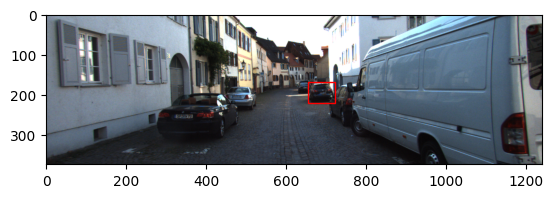

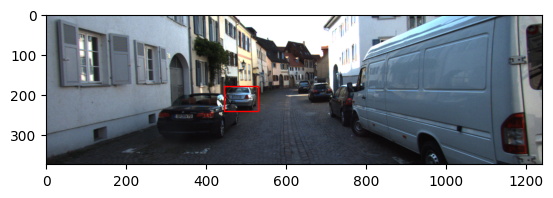

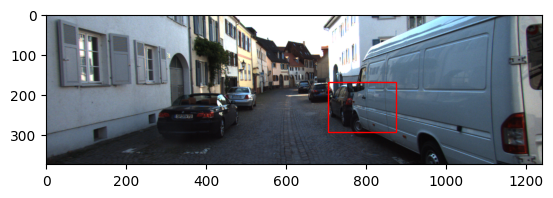

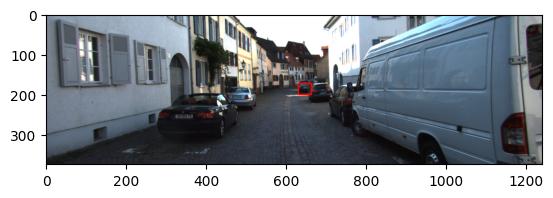

[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceServers
[Open3D INFO] [Called HTTP API (custom handshake)] /api/call


In [50]:
def visualize_cars(num_cars):
    # Get cars
    cars = []
    for label in labels:
        if label['type'] == 'Car':
            cars.append(label)
        if len(cars) == num_cars:
            break

    # Generate bbox
    lines = []
    for car in cars:
        lines.append(generate_bbox(car, calib))
        generate_img(img_path, car)
        

    # Draw bbox into point cloud
    draw([pcd_bin, *lines], width=900, height=600, point_size=2)

visualize_cars(10)